In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Lara Baalbaki (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# 1D deconvolution with Besov priors
### Lara Baalbaki (labaa@dtu.dk)

In this notebook, our primary goal is to address the 1D deconvolution problem within a Bayesian framework, employing the Besov priors. The Besov prior, a wavelet-based approach, has distinctive features such as edge-preservation, making it particularly plausible for applications in image processing. We have implemented the 1D Besov class, encapsulating its functionalities and utilities, in the accompanying file `besov_prior.py`.

The subsequent sections of this notebook will serve as a demonstration of the practical utilization of the 1D Besov class, showcasing its efficacy in tackling deconvolution challenges.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cuqi
from scipy import sparse
# Import the implemented Besov prior
from besov_prior import besov_prior

In [3]:
# Set seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.7.0


## 1. Problem description

Our problem under consideration is as follows:
$$y = Ax + \epsilon$$
where A is the convolution operator with a periodic boundary and a Gaussian kernal, and $\epsilon$ is the Gaussian noise.

CUQIpy has prepared a bunch of pre-defined test problems, e.g., `Deconvolution1D`, which we will be huge use of in this notebook.

In [5]:
J = 9
n = 2**J
std = 0.05
model1, data1, probInfo1 = cuqi.testproblem.Deconvolution1D(dim=n,noise_std=std,phantom='pc').get_components()
print(probInfo1)

ProblemInfo with the following set attributes:
['exactSolution', 'infoString', 'exactData']
 infoString: Noise type: Additive Gaussian with std: 0.05


We now plot the exact solution and the noisy data.

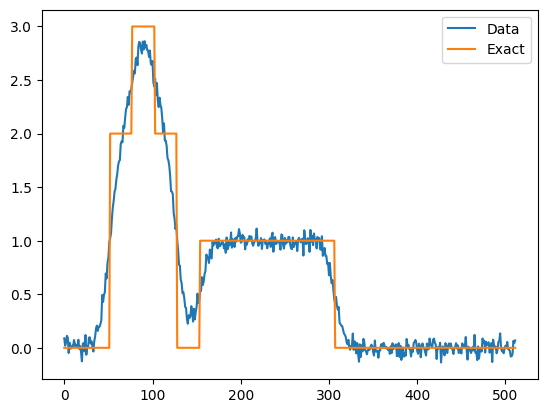

In [6]:
plt.figure()
plt.plot(data1, label='Data')
plt.plot(probInfo1.exactSolution,label='Exact')
plt.legend()

## 2. The prior

Our Besov prior has the the following probablity density:

$$\Pi_{Besov} \propto exp(-\frac{\gamma}{p} ||Bx||_p^p)$$

where $$Bx \approx \{2^{j(s+\frac{d}{2}-frac{d}{p})} <\Xi_{func}, \psi_{j,k}>\}$$
and $\gamma,$ p, s are our parameters and $d$ is the dimension.

We can define a `UserDefinedDistribution` by providing a function handle to evalute the logpdf of the Besov prior. Here we also provide a second function handle to evalute the gradient of the logpdf and this will allow the user to use gradient-based MCMC sampling methods.

In [7]:
s = 1
p = 1.5
wavelet = 'db1'
gamma = 10
prior = besov_prior(J,gamma,0,s,p,wavelet)
B_T = sparse.csr_matrix(np.transpose(prior.compute_besov_matrix()))
logpdf = lambda x:-gamma/p*np.linalg.norm(prior.wavelet_weigth(x),ord=p)**p
gradient = lambda x:-gamma*B_T@(np.sign(prior.wavelet_weigth(x))*np.abs(prior.wavelet_weigth(x))**(p-1))
x=cuqi.distribution.UserDefinedDistribution(dim=n, logpdf_func=logpdf, gradient_func=gradient)

## 3. The likelihood

We can specify a Gausssian model for the likelihood as follows:

In [8]:
y = cuqi.distribution.Gaussian(model1(x),std**2)

## 4. Posterior
In the Bayesian setting, we have the posterior $p(x|y) \sim L(x|y)p(x)$. With the just created prior `x` and likelihood `y`, we are now ready to define the posterior `posterior`:

In [9]:
joint = cuqi.distribution.JointDistribution(y,x)
posterior = joint(y=data1)

We can easily get the Maximum A Posteriori (MAP) estimate of the posterior with the help of `BayesianProblem`.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


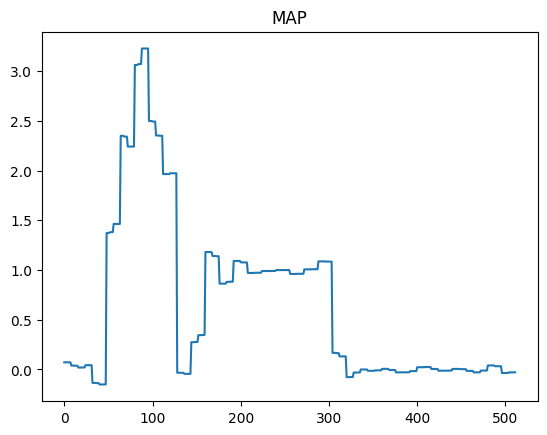

In [10]:
BP = cuqi.problem.BayesianProblem(y, x).set_data(y=data1)
MAP = BP.MAP(disp=True,x0=np.ones((n)))

# Plot
plt.figure()
plt.plot(MAP)
plt.title('MAP')
plt.show()

As our Besov prior is equiped with a gradient function, we can use advanced gradient-based sampling strategies. Here we choose the No-U-Turn Sampler (NUTS), a variant of the Hamiltonian Monte Carlo (HMC) algorithm.

In [11]:
sampler = cuqi.sampler.NUTS(posterior)
samples = sampler.sample_adapt(1000,300)

Sample 1300 / 1300


In [12]:
# Remove burn-in and thin samples
final_samples = samples.burnthin(0,2)

Selecting 5 randomly chosen variables


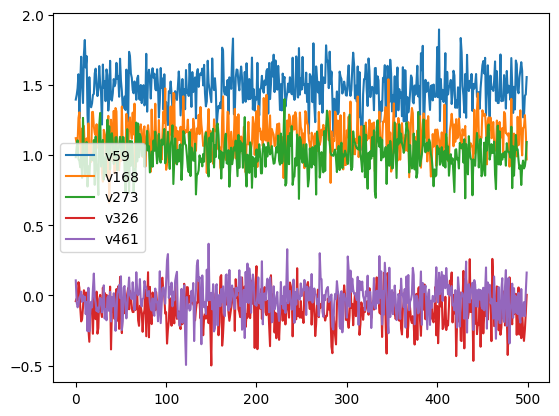

In [13]:
# Plot the samples
final_samples.plot_chain()

We can further check the correlation between the samples using the autocorrelation plot.

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v11'}>, <Axes: title={'center': 'v70'}>,
        <Axes: title={'center': 'v72'}>],
       [<Axes: title={'center': 'v99'}>,
        <Axes: title={'center': 'v312'}>, <Axes: >]], dtype=object)

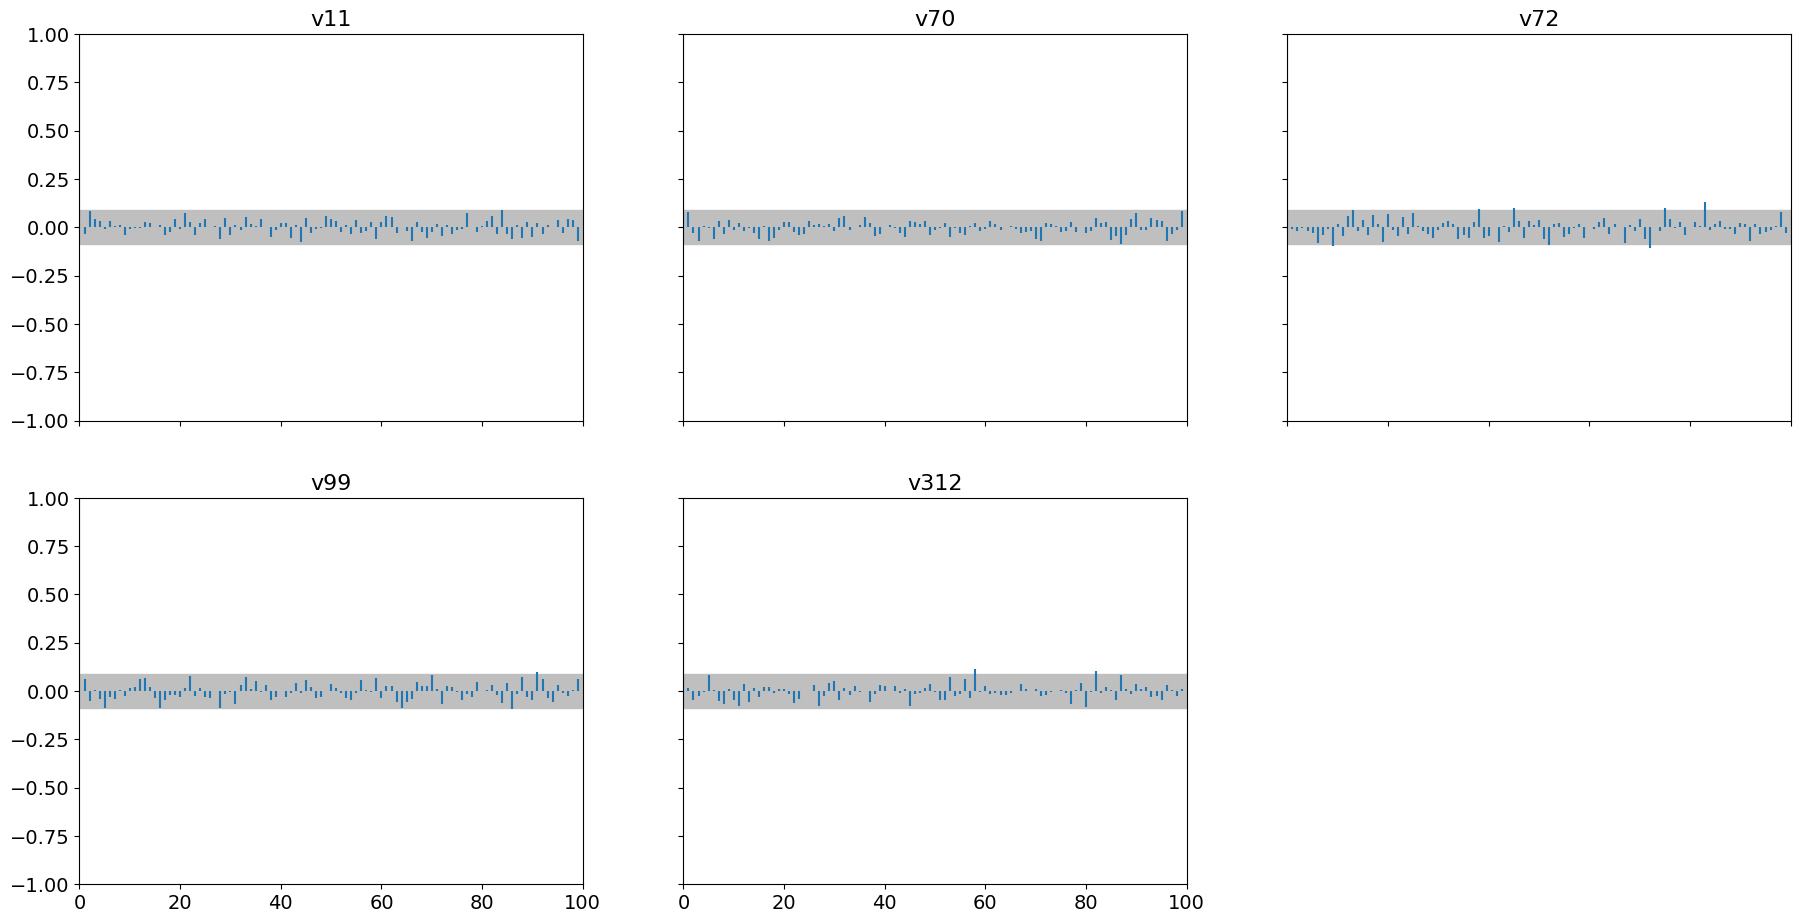

In [14]:
final_samples.plot_autocorrelation()

Finally, we plot the posterior credible interval.

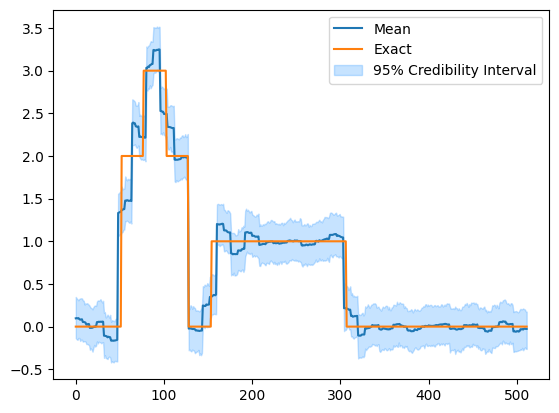

In [15]:
final_samples.plot_ci(95,exact=probInfo1.exactSolution)